### PuLP

Valor óptimo (Cmax): 105.0


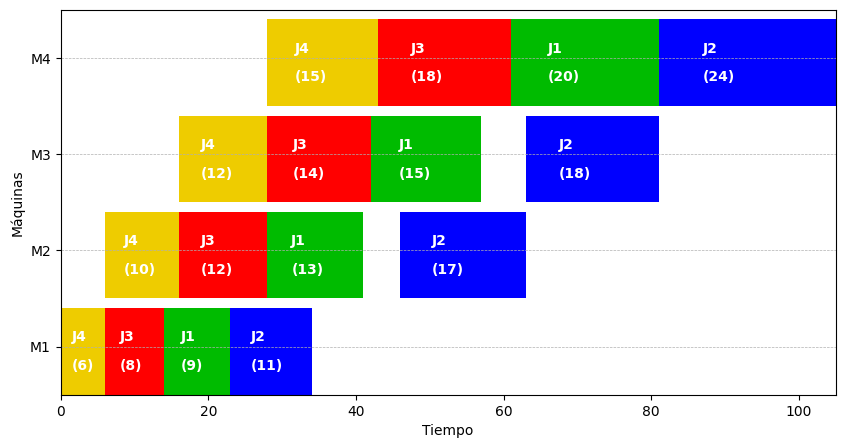

In [9]:
import pulp as lp
import numpy as np
import matplotlib.pyplot as plt

# Datos proporcionados
T = np.array([[9, 13, 15, 20],
              [11, 17, 18, 24],
              [8, 12, 14, 18],
              [6, 10, 12, 15]])
T = T.transpose()
T = T.tolist()

N = len(T)  # Número de trabajos
M = len(T[0])  # Número de máquinas
P = 100000  # Una constante grande, suficiente para actuar como 'M' en el modelo

# Crear el modelo
model = lp.LpProblem("Liao-You_Model", lp.LpMinimize)

# Definir las variables
D = lp.LpVariable.dicts("D", (range(N), range(N)), cat='Binary')
S = lp.LpVariable.dicts("S", (range(M), range(N)), lowBound=0, cat='Integer')
q = lp.LpVariable.dicts("q", (range(M), range(N), range(N)), lowBound=0,cat='Integer')
C_max = lp.LpVariable("C_max", lowBound=0, cat='Integer')

# Función objetivo
model += C_max

# Restricciones

# Flujo de trabajos en cada máquina
for r in range(M-1):
    for i in range(N):
        model += S[r][i] + T[r][i] <= S[r+1][i], f"Job_Flow_{i}_{r}"

# Secuencia de trabajos en cada máquina
for r in range(M):
    for i in range(N):
        for k in range(i+1, N):
            model += S[r][i] - S[r][k] + P * D[i][k] - T[r][k] == q[r][i][k], f"Job_Sequence_{r}_{i}_{k}"

# Precedencia de trabajos en las máquinas
for r in range(M):
    for i in range(N):
        for k in range(i+1, N):           
            model += P - T[r][i] - T[r][k] >= q[r][i][k], f"Surplus_Positive_{r}_{i}_{k}"

# Restricciones de makespan
for i in range(N):
    model += C_max >= S[M-1][i] + T[M-1][i], f"Job_Completion_{i}"

# Resolver el modelo
model.solve()

# Imprimir la solución
print(f"Valor óptimo (Cmax): {model.objective.value()}")

# Carta gantt
matriz = []
for r in range(M):
    maquina = []
    for i in range(N):
        maquina.append([int(lp.value(S[r][i])),int(lp.value(S[r][i]) + T[r][i])])
    matriz.append(maquina)

fig, gantt = plt.subplots(figsize=(10, 5))
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, lp.value(model.objective))
gantt.set_ylim(0, M * 10)
gantt.set_yticks(np.arange(5, M * 10, 10))
gantt.set_yticklabels(['M' + str(i) for i in range(1, M+1)])
gantt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
colores = ['#00BB00', 'blue', 'red', '#EECC00']

for r in range(M):
    for j in range(N):
        inicio = matriz[r][j][0]
        duracion = matriz[r][j][1] - matriz[r][j][0]
        gantt.broken_barh([(inicio, duracion)], ((r) * 10, 9), facecolors=colores[j])
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 6), s='J'+str(j+1), va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 3), s='('+str(duracion)+')', va='center', color='white', fontweight='bold') 

### CPLEX

Objective Value: 105.0


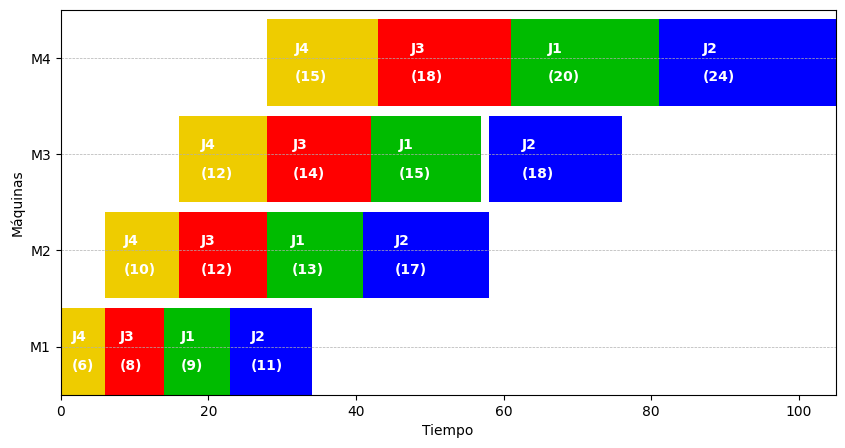

In [10]:
from docplex.mp.model import Model
import numpy as np
import matplotlib.pyplot as plt

# Datos proporcionados
T = np.array([[9, 13, 15, 20],
              [11, 17, 18, 24],
              [8, 12, 14, 18],
              [6, 10, 12, 15]])
T = T.transpose()

N = len(T[0])  # Número de trabajos
M = len(T)     # Número de máquinas
P = 100000  # Una constante grande, suficiente para actuar como 'M' en el modelo


# Crear el modelo
model_cplex = Model(name="Liao-You_Model")

# Definir las variables
D = {(i, k): model_cplex.binary_var(name=f"D_{i}_{k}") for i in range(N) for k in range(N)}
S = {(r, i): model_cplex.integer_var(name=f"S_{r}_{i}") for r in range(M) for i in range(N)}
q = {(r, i, k): model_cplex.integer_var(name=f"q_{r}_{i}_{k}") for r in range(M) for i in range(N) for k in range(N)}
C_max = model_cplex.integer_var(name="C_max")

# Función objetivo
model_cplex.minimize(C_max)

# Restricciones
# Flujo de trabajos en cada máquina
for r in range(M-1):
    for i in range(N):
        model_cplex.add_constraint(S[r, i] + T[r][i] <= S[r+1, i])


# Secuencia de trabajos en cada máquina
for r in range(M):
    for i in range(N):
        for k in range(i+1, N):
            model_cplex.add_constraint(S[r, i] - S[r, k] + P * D[i, k] - T[r][k] == q[r, i, k])

# Precedencia de trabajos en las máquinas
for r in range(M):
    for i in range(N):
        for k in range(i+1, N):  
            model_cplex.add_constraint(P - T[r][i] - T[r][k] >= q[r, i, k])         

# Restricciones de makespan
for i in range(N):
    model_cplex.add_constraint(C_max >= S[M-1, i] + T[M-1][i])

# Resolver el modelo
solution_cplex = model_cplex.solve()

# Imprimir la solución
print("Objective Value:", model_cplex.objective_value)

# Carta Gannt
matriz = []
for r in range(M):
    maquina = []
    for i in range(N):
        maquina.append([int(S[r,i].solution_value),int(S[r,i].solution_value + T[r][i])])
    matriz.append(maquina)

fig, gantt = plt.subplots(figsize=(10, 5))
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, model_cplex.objective_value)
gantt.set_ylim(0, M * 10)
gantt.set_yticks(np.arange(5, M * 10, 10))
gantt.set_yticklabels(['M' + str(i) for i in range(1, M+1)])
gantt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
colores = ['#00BB00', 'blue', 'red', '#EECC00']

for r in range(M):
    for j in range(N):
        inicio = matriz[r][j][0]
        duracion = matriz[r][j][1] - matriz[r][j][0]
        gantt.broken_barh([(inicio, duracion)], ((r) * 10, 9), facecolors=colores[j])
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 6), s='J'+str(j+1), va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 3), s='('+str(duracion)+')', va='center', color='white', fontweight='bold') 

### Gurobi

Objective Value: 105.0


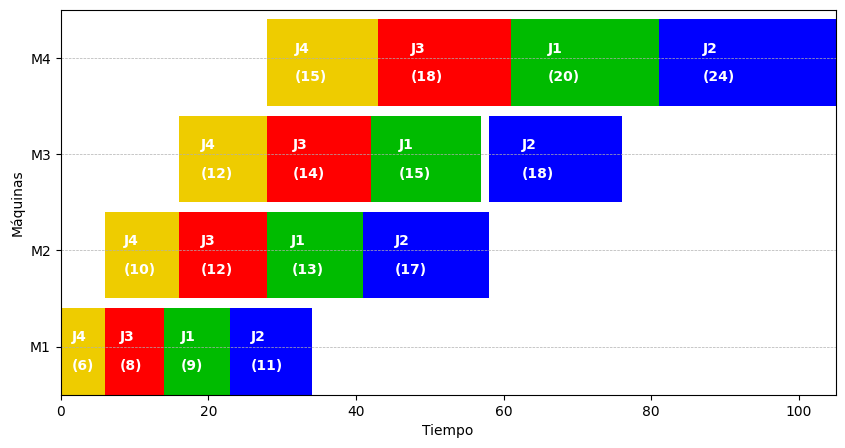

In [2]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Datos proporcionados
T = np.array([[9, 13, 15, 20],
              [11, 17, 18, 24],
              [8, 12, 14, 18],
              [6, 10, 12, 15]])
T = T.transpose()
T = T.tolist()

N = len(T[0])  # Número de trabajos
M = len(T)  # Número de máquinas
P = 100000  # Una constante grande, suficiente para actuar como 'M' en el modelo

# Crear el modelo
model = gp.Model("Liao-You_Model")

# Definir las variables
D = model.addVars(range(N), range(N), vtype=GRB.BINARY, name="D")
S = model.addVars(range(M), range(N), lb=0, vtype=GRB.INTEGER, name="S")
q = model.addVars(range(M), range(N), range(N), lb=0, vtype=GRB.INTEGER, name="q")
C_max = model.addVar(lb=0, vtype=GRB.INTEGER, name="C_max")

# Función objetivo
model.setObjective(C_max, sense=GRB.MINIMIZE)

# Restricciones

# Flujo de trabajos en cada máquina
for r in range(M-1):
    for i in range(N):
        model.addConstr(S[r,i] + T[r][i] <= S[r+1,i], f"Job_Flow_{i}_{r}")

# Secuencia de trabajos en cada máquina
for r in range(M):
    for i in range(N):
        for k in range(i+1, N):
            model.addConstr(S[r,i] - S[r,k] + P * D[i,k] - T[r][k] == q[r,i,k], f"Job_Sequence_{r}_{i}_{k}")

# Precedencia de trabajos en las máquinas
for r in range(M):
    for i in range(N):
        for k in range(i+1, N):
            model.addConstr(P - T[r][i] - T[r][k] >= q[r,i,k])

# Restricciones de makespan
for i in range(N):
    model.addConstr(C_max >= S[M-1,i] + T[M-1][i], f"Job_Completion_{i}")

# Resolver el modelo
model.setParam('OutputFlag', False)
model.optimize()

# Imprimir la solución
print("Objective Value:", model.objVal)

# Carta Gantt
matriz = []
for r in range(M):
    maquina = []
    for i in range(N):
        maquina.append([int(S[r,i].x), int(S[r,i].x + T[r][i])])
    matriz.append(maquina)

fig, gantt = plt.subplots(figsize=(10, 5))
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, model.objVal)
gantt.set_ylim(0, M * 10)
gantt.set_yticks(np.arange(5, M * 10, 10))
gantt.set_yticklabels(['M' + str(i) for i in range(1, M+1)])
gantt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
colores = ['#00BB00', 'blue', 'red', '#EECC00']

for r in range(M):
    for j in range(N):
        inicio = matriz[r][j][0]
        duracion = matriz[r][j][1] - matriz[r][j][0]
        gantt.broken_barh([(inicio, duracion)], ((r) * 10, 9), facecolors=colores[j])
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 6), s='J'+str(j+1), va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 3), s='('+str(duracion)+')', va='center', color='white', fontweight='bold')

# Mostrar el gráfico
plt.show()
